In [104]:
import os
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.transforms import AddSelfLoops
from torch_geometric.nn import to_hetero
from mscproject.transforms import RemoveSelfLoops

from mscproject.datasets import CompanyBeneficialOwners
from mscproject.transforms import RemoveSelfLoops
import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

[autoreload of mscproject.experiment failed: Traceback (most recent call last):
  File "/home/domvwt/projects/msc-thesis/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/domvwt/projects/msc-thesis/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/domvwt/.pyenv/versions/3.9.12/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/domvwt/projects/msc-thesis/src/mscproject/experiment.py", line 34
    re

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {str(device).upper()}")

dataset_path = "data/pyg/"

dataset = CompanyBeneficialOwners(dataset_path, to_undirected=True)
dataset = dataset.data.to(device)

Using device: CPU


## GCN

### TODO

- Focus on GCN and GraphSAGE
- Choose correct depth and layer size
- Choose best optimizer
- Choose best aggregation functions
- Leave out weight decay and dropout for now

In [106]:
def get_model_and_optimiser():
    model = mod.GCN(
        in_channels=-1,
        out_channels=1,
        hidden_channels=2**5,
        num_layers=5,
        dropout=0.0,
        metadata=dataset.metadata,
        act="leaky_relu",
        aggr="sum",
    )

    model = to_hetero(model, dataset.metadata(), aggr="sum")

    # Initialise lazy modules.
    with torch.no_grad():
        _ = model(dataset.x_dict, dataset.edge_index_dict)

    optimiser = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
    # optimiser = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0)
    # optimiser = torch.optim.RMSprop(model.parameters(), lr=0.005, weight_decay=0)

    return model, optimiser

In [107]:
train_losses = []
val_losses = []
val_aprcs = []

model, optimiser = get_model_and_optimiser()

In [108]:
for i in tqdm(range(500)):
    # model.reset_parameters()
    loss = exp.train(model, dataset, optimiser)
    eval_result = exp.evaluate(model, dataset)
    train_losses.append(eval_result.train.loss)
    val_losses.append(eval_result.val.loss)
    val_aprcs.append(eval_result.val.average_precision)

100%|██████████| 500/500 [05:05<00:00,  1.64it/s]


In [114]:
eval_result.train.loss

3.9280591011047363

In [115]:
loss

3.322829246520996

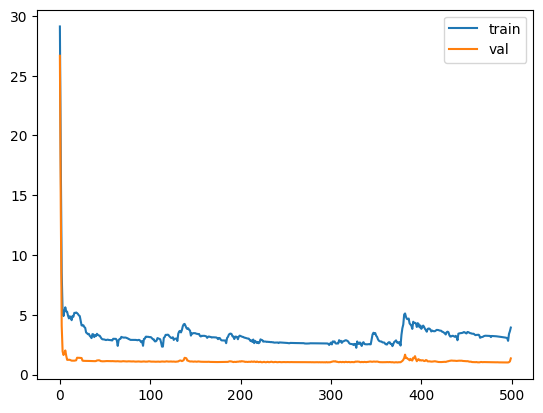

In [116]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
# plt.ylim(0, 2)

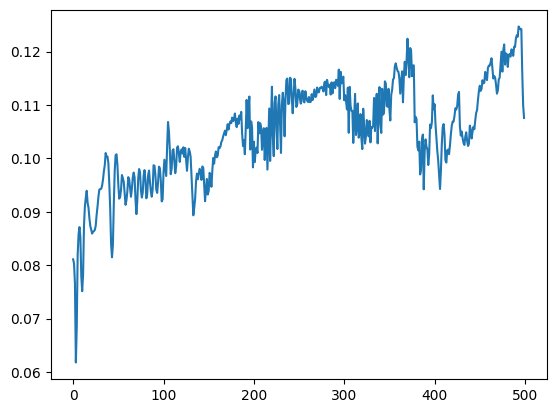

In [117]:
plt.plot(val_aprcs)

In [113]:
np.array(val_aprcs).max()

0.12470268458127975